* __DCC163-2021.1-A - UFJF__
* __Alexandre Vieira Pereira Pacelli - 201865502B__
* __Davi Magalhães Pereira - 201865558C__

# Otimização de portfólio de investimentos

In [263]:
import pandas as pd
import numpy as np
import yfinance as yf
from docplex.mp.model import Model
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from re import sub
from decimal import Decimal
import sys
import docplex

## 1. Modelagem

### 1.1. Variáveis

Como variáveis do modelo temos todos os ativos pertencentes à carteira de investimentos do investidor.

Sendo x[i], para todo e qualquer ativo, a porcentagem a ser investida no mesmo de acordo com a resposta do modelo (seguindo restrições e funcão objetivo)

### 1.2. Restrições

Restrições Solicitadas pelo Investidor:

* Ativos RENDA FIXA == 15% do total investido
* Ativos FUNDOS IMOBILIÁRIOS == 15% do total investido
* Ativos GOLD11, HASH11, BIAU39 == 5% do total investido
* Ativos DEMAIS AÇÕES == 65% do total investido
* TODOS os ATIVOS devem possuir um investimento >= 1% do total investido
* TODOS os ATIVOS devem possuir um investimento <= 15% do total investido
* Soma de todos os investimentos == 100%


Restrições Gerais presentes em todos os modelos testados para o trabalho:

* TODOS os ATIVOS devem possuir um investimento >= 0.5% do total investido
* TODOS os ATIVOS devem possuir um investimento <= 15% do total investido
* Soma de todos os investimentos == 100%
* O RETORNO TOTAL do investimento >= 8% _OU_ A VARIÃNCIA TOTAL do investimento <= 60%


### 1.3. Função objetivo

Como Função Objetivo, o investidor despertou interesse em descobrir os ativos de MAIOR RETORNO e de MENOR VARIÂNCIA em sua carteira de investimentos.

Portanto, elaboramos as seguintes Funções Objetivo para os dois interesses acima, onde:
* 'i' = Cada Ativo da carteira de investimentos
* 'r' = Retorno em % de cada ativo desde sua compra
* 'v' = Variância de cada ativo desde sua compra

\begin{equation}
z_{min} =\sum_{i=1}^{n} \mbox{v}_i
\end{equation}

\begin{equation}
z_{max} =\sum_{i=1}^{n} \mbox{r}_i
\end{equation}

## 2. Implementação

### 2.1 Coleta de Dados

Realizamos alguns testes com a API de dados do Yahoo e percebemos que algumas ações e rendas fixas possuíam dados faltantes ou inexistentes, então baixamos essas e coletamos os dados manualmente.

In [2]:
variables = ['XPCI11.SA KNRI11.SA XINA11 VIVT3 TRPL4 TRIS3 TGAR11 TEND3 TAEE11 SULA11 RAIZ4 OIBR3 MXRF11 JHSF3 IVVB11 HASH11 GOLD11 GOAU4 GGBR4 FESA4 EGIE3 DIRR3 CYRE3 CSAN3 COGN3 BRPR3 BRML3 BOVA11 BIAU39 BABA34 AURA33 ALUP11 ALSO3']

# par = ['-22.08 -7.45 -8.94 -23.36 +0.29 -19.57 +24.53 -12.05 -3.51 -38.0 -0.8 +7.34 +9.53 -5.79 -3.85 +1.41 +2.38 +16.51 -7.68 -6.52 -17.04 +4.83 -14.84 -3.45 +22.01 +4.70 -1.77 -27.99 +14.35 -5.53 +8.66']

In [3]:
return_dict = {'IPCA': -7.18, 'Selic': 0, 'Prefixado': 0, 'KNRI11.SA': 0, 'XPCI11.SA': 0, 'XINA11.SA': -22.08, 'VIVT3.SA': -7.45, 'TRPL4.SA': -8.94, 'TRIS3.SA': -23.36, 'TGAR11.SA': 0.29, 'TEND3.SA': -19.57, 'TAEE11.SA': 24.53, 'SULA11.SA': -12.05, 'RAIZ4.SA': -3.51, 'OIBR3.SA': -38.0, 'MXRF11.SA': -0.8, 'JHSF3.SA': 7.34, 'IVVB11.SA': 9.53, 'HASH11.SA': -5.79, 'GOLD11.SA': -3.85, 'GOAU4.SA': 1.41, 'GGBR4.SA': 2.38, 'FESA4.SA': 16.51, 'EGIE3.SA': -7.68, 'DIRR3.SA': -6.52, 'CYRE3.SA': -17.04, 'CSAN3.SA': 4.83, 'COGN3.SA': -14.84, 'BRPR3.SA': -3.45, 'BRML3.SA': 22.01, 'BOVA11.SA': 4.70, 'BIAU39.SA': -1.77, 'BABA34.SA': -27.99, 'AURA33.SA': 14.35, 'ALUP11.SA': -5.53, 'ALSO3.SA':8.66}
return_dict

{'IPCA': -7.18,
 'Selic': 0,
 'Prefixado': 0,
 'KNRI11.SA': 0,
 'XPCI11.SA': 0,
 'XINA11.SA': -22.08,
 'VIVT3.SA': -7.45,
 'TRPL4.SA': -8.94,
 'TRIS3.SA': -23.36,
 'TGAR11.SA': 0.29,
 'TEND3.SA': -19.57,
 'TAEE11.SA': 24.53,
 'SULA11.SA': -12.05,
 'RAIZ4.SA': -3.51,
 'OIBR3.SA': -38.0,
 'MXRF11.SA': -0.8,
 'JHSF3.SA': 7.34,
 'IVVB11.SA': 9.53,
 'HASH11.SA': -5.79,
 'GOLD11.SA': -3.85,
 'GOAU4.SA': 1.41,
 'GGBR4.SA': 2.38,
 'FESA4.SA': 16.51,
 'EGIE3.SA': -7.68,
 'DIRR3.SA': -6.52,
 'CYRE3.SA': -17.04,
 'CSAN3.SA': 4.83,
 'COGN3.SA': -14.84,
 'BRPR3.SA': -3.45,
 'BRML3.SA': 22.01,
 'BOVA11.SA': 4.7,
 'BIAU39.SA': -1.77,
 'BABA34.SA': -27.99,
 'AURA33.SA': 14.35,
 'ALUP11.SA': -5.53,
 'ALSO3.SA': 8.66}

In [4]:
selic = pd.read_csv('data/Selic2027.csv')
selic.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima'], axis=1, inplace=True)
selic.head()

,Último
0,"10.785,177"
1,"10.783,554"
2,"10.781,931"
3,"10.782,094"
4,"10.780,843"


In [5]:
selic['Último'] = selic['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
selic.head()

,Último
0,10785.177
1,10783.554
2,10781.931
3,10782.094
4,10780.843


In [6]:
var_dict = {'Selic': selic['Último'].var()}
var_dict

{'Selic': 7605.365255462518}

In [7]:
prefixado = pd.read_csv('data/Prefixado2026.csv')
prefixado.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima'], axis=1, inplace=True)
prefixado['Último'] = prefixado['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
prefixado.head()

,Último
0,656.53
1,660.99
2,666.85
3,671.42
4,668.50


In [8]:
var_dict['Prefixado'] = prefixado['Último'].var()
var_dict

{'Selic': 7605.365255462518, 'Prefixado': 271.49614009511976}

In [9]:
ipca = pd.read_csv('data/IMBB11.csv', sep='\t')
ipca.drop(['Data', 'Variação', 'Abertura', 'Máxima', 'Mínima', 'Variação (%)', 'Volume'], axis=1, inplace=True)
ipca['Fechamento'] = ipca['Fechamento'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
ipca.rename(columns = {'Fechamento': 'Último'},inplace=True)
ipca.head()

,Último
0,103.65
1,103.25
2,103.65
3,104.30
4,104.35


In [10]:
var_dict['IPCA'] = ipca['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195}

In [11]:
hash11 = pd.read_csv('data/HASH11.csv')
hash11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
hash11['Último'] = hash11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
hash11.head()

,Último
0,43.06
1,43.15
2,44.30
3,45.00
4,42.72


In [12]:
var_dict['HASH11.SA'] = hash11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088}

In [13]:
tgar11 = pd.read_csv('data/TGAR11.csv')
tgar11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
tgar11['Último'] = tgar11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
tgar11.head()

,Último
0,123.04
1,122.79
2,124.12
3,125.00
4,124.00


In [14]:
var_dict['TGAR11.SA'] = tgar11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853}

In [15]:
biau39 = pd.read_csv('data/BIAU39.csv')
biau39.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
biau39['Último'] = biau39['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
biau39.head()

,Último
0,45.50
1,44.65
2,44.88
3,44.35
4,43.77


In [16]:
var_dict['BIAU39.SA'] = biau39['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375}

In [17]:
gold11 = pd.read_csv('data/GOLD11.csv')
gold11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
gold11['Último'] = gold11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
gold11.head()

,Último
0,10.22
1,10.06
2,10.10
3,9.98
4,9.85


In [18]:
var_dict['GOLD11.SA'] = gold11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956}

In [19]:
xina11 = pd.read_csv('data/XINA11.csv')
xina11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
xina11['Último'] = xina11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
xina11.head()

,Último
0,8.96
1,8.74
2,8.98
3,9.11
4,9.16


In [20]:
var_dict['XINA11.SA'] = xina11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956,
 'XINA11.SA': 1.0428390993788819}

Coletados os dados faltantes podemos obter o restante pela API.

In [21]:
df = yf.download(tickers="KNRI11.SA XPCI11.SA VIVT3.SA TRPL4.SA TRIS3.SA TEND3.SA TAEE11.SA SULA11.SA RAIZ4.SA OIBR3.SA MXRF11.SA JHSF3.SA IVVB11.SA GOAU4.SA GGBR4.SA FESA4.SA EGIE3.SA DIRR3.SA CYRE3.SA CSAN3.SA COGN3.SA BRPR3.SA BRML3.SA BOVA11.SA BABA34.SA AURA33.SA ALUP11.SA ALSO3.SA",
                 period='1y')#start="2018-01-01", end="2021-08-11")

[*********************100%***********************]  28 of 28 completed


In [22]:
df.head()

Adj Close                                                       \
             ALSO3.SA  ALUP11.SA  AURA33.SA  BABA34.SA  BOVA11.SA BRML3.SA   
Date                                                                         
2020-09-10  26.941750  23.105961  59.627628  50.964287  95.040001     9.47   
2020-09-11  26.584774  22.747652  58.600853  51.806786  94.480003     9.31   
2020-09-14  27.705282  22.689550  59.739639  51.616070  96.510002     9.86   
2020-09-15  27.298727  22.873545  60.859756  52.439999  96.459999     9.77   
2020-09-16  27.953182  23.067225  60.719746  52.294998  95.910004     9.98   

                                                     ...    Volume             \
            BRPR3.SA COGN3.SA   CSAN3.SA   CYRE3.SA  ... MXRF11.SA   OIBR3.SA   
Date                                                 ...                        
2020-09-10  9.126679     5.88  18.671677  21.882029  ...    684869  322110300   
2020-09-11  8.979948     5.70  18.350433  21.536139  ...    664305  318702800   
2020-09-14  9.576654     5.98  18.345491  22.400862  ...    851425  404415700   
2020-09-15  9.547308     5.80  18.708744  22.264324  ...    483390  120170500   
2020-09-16  9.674476     5.83  18.587660  21.854721  ...    547692  107127900   

                                                                             \
           RAIZ4.SA SULA11.SA TAEE11.SA TEND3.SA TRIS3.SA TRPL4.SA VIVT3.SA   
Date                                                                          
2020-09-10      NaN   2809474   2379800   730600  1151100  1393700    60100   
2020-09-11      NaN   2513661   2792300   782800  1168300  1572100    89100   
2020-09-14      NaN   1759865   2116800   989700  1184300  1306000    95300   
2020-09-15      NaN   2515065   2622800  1211900   869500   770200    88700   
2020-09-16      NaN   2056759   2195500   811100  3396100  1175900   146100   

                      
           XPCI11.SA  
Date                  
2020-09-10      8679  
2020-09-11     23228  
2020-09-14     22093  
2020-09-15     12974  
2020-09-16     16583  

[5 rows x 168 columns]

In [23]:
df_close = df['Close']
df_close.head()

,ALSO3.SA,ALUP11.SA,AURA33.SA,BABA34.SA,BOVA11.SA,BRML3.SA,BRPR3.SA,COGN3.SA,CSAN3.SA,CYRE3.SA,...,MXRF11.SA,OIBR3.SA,RAIZ4.SA,SULA11.SA,TAEE11.SA,TEND3.SA,TRIS3.SA,TRPL4.SA,VIVT3.SA,XPCI11.SA
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,27.170000,23.860001,63.880001,50.964287,95.040001,9.47,9.33,5.88,18.889999,24.040001,...,10.54,1.66,NaN,38.874454,28.709999,30.389999,11.70,21.250000,48.400002,87.750000
2020-09-11,26.809999,23.490000,62.779999,51.806786,94.480003,9.31,9.18,5.70,18.565001,23.660000,...,10.51,1.63,NaN,38.337616,28.379999,30.330000,11.53,21.059999,47.990002,87.870003
2020-09-14,27.940001,23.430000,64.000000,51.616070,96.510002,9.86,9.79,5.98,18.559999,24.610001,...,10.37,1.85,NaN,38.763386,28.600000,30.980000,12.05,21.100000,48.000000,87.180000
2020-09-15,27.530001,23.620001,65.199997,52.439999,96.459999,9.77,9.76,5.80,18.927500,24.459999,...,10.59,1.81,NaN,38.208035,28.559999,30.610001,11.83,21.100000,48.000000,88.239998
2020-09-16,28.190001,23.820000,65.050003,52.294998,95.910004,9.98,9.89,5.83,18.805000,24.010000,...,10.67,1.82,NaN,38.180267,28.709999,29.889999,12.33,21.120001,47.369999,88.050003


In [24]:
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956,
 'XINA11.SA': 1.0428390993788819}

In [25]:
for column in df_close.columns:
    var_dict[column] = df_close[column].var()

E por fim temos os dois dicionários para formar a função objetivo de um tipo de carteira que foi solicitado pelo investidor. O mesmo nos explicou que gostaria de aplicar mais dinheiro em ações/fundos/rendas fixas menos voláteis e ao mesmo tempo, levar em consideração quanto cada investimento o retornou desde sua compra.

In [26]:
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956,
 'XINA11.SA': 1.0428390993788819,
 'ALSO3.SA': 4.253091705141663,
 'ALUP11.SA': 1.7411436790679402,
 'AURA33.SA': 26.881560249293535,
 'BABA34.SA': 62.98481591661332,
 'BOVA11.SA': 86.71058342043412,
 'BRML3.SA': 0.6512137014481456,
 'BRPR3.SA': 0.4014562660630759,
 'COGN3.SA': 0.40698245684651546,
 'CSAN3.SA': 7.423670289023585,
 'CYRE3.SA': 7.920471593736659,
 'DIRR3.SA': 0.7631313546989098,
 'EGIE3.SA': 4.319634234470608,
 'FESA4.SA': 156.57266635152655,
 'GGBR4.SA': 19.253090980314063,
 'GOAU4.SA': 3.908424196154461,
 'IVVB11.SA': 362.5801271441705,
 'JHSF3.SA': 0.19464050217995957,
 'KNRI11.SA': 98.00689251418223,
 'MXRF11.SA': 0.05406089682070364,
 'OIBR3.SA': 0.1293336654404456,
 'RAIZ4.SA': 0.05223646160831812,
 'SULA11.SA': 14.53570692160266,
 'TAEE11.SA

In [27]:
return_dict

{'IPCA': -7.18,
 'Selic': 0,
 'Prefixado': 0,
 'KNRI11.SA': 0,
 'XPCI11.SA': 0,
 'XINA11.SA': -22.08,
 'VIVT3.SA': -7.45,
 'TRPL4.SA': -8.94,
 'TRIS3.SA': -23.36,
 'TGAR11.SA': 0.29,
 'TEND3.SA': -19.57,
 'TAEE11.SA': 24.53,
 'SULA11.SA': -12.05,
 'RAIZ4.SA': -3.51,
 'OIBR3.SA': -38.0,
 'MXRF11.SA': -0.8,
 'JHSF3.SA': 7.34,
 'IVVB11.SA': 9.53,
 'HASH11.SA': -5.79,
 'GOLD11.SA': -3.85,
 'GOAU4.SA': 1.41,
 'GGBR4.SA': 2.38,
 'FESA4.SA': 16.51,
 'EGIE3.SA': -7.68,
 'DIRR3.SA': -6.52,
 'CYRE3.SA': -17.04,
 'CSAN3.SA': 4.83,
 'COGN3.SA': -14.84,
 'BRPR3.SA': -3.45,
 'BRML3.SA': 22.01,
 'BOVA11.SA': 4.7,
 'BIAU39.SA': -1.77,
 'BABA34.SA': -27.99,
 'AURA33.SA': 14.35,
 'ALUP11.SA': -5.53,
 'ALSO3.SA': 8.66}

### 2.2 Implementação do Modelo

Com os dados de variância e retorno obtidos, podemos agora otimizar o portfólio.

In [476]:
fi = ['XPCI11.SA', 'KNRI11.SA', 'MXRF11.SA', 'TGAR11.SA']
rf = ['IPCA', 'Selic', 'Prefixado']
ghb = ['GOLD11.SA', 'HASH11.SA', 'BIAU39.SA']

In [592]:
a = [x for x in keys if x not in (rf)]

In [478]:
keys = list(return_dict.keys())
r = [x for x in keys if x not in (fi + rf + ghb)]

#### 2.2.1 Modelo mantendo todas as restrições solicitadas

* Minimizando a variância e com retorno mínimo de 8%

In [479]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [480]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [481]:
model.add_constraint(model.sum(x[i] for i in fi) == 0.15)
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in ghb) == 0.05)
model.add_constraint(model.sum(x[i] for i in r) == 0.65)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [482]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 2 columns.
Aggregator did 1 substitutions.
Reduced LP has 4 rows, 33 columns, and 64 nonzeros.
Presolve time = 0.00 sec. (0.06 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            48.819390


In [483]:
model.print_solution()

objective: 55.087
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.135
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.005
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.009
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.040
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.086


In [484]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [485]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [486]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [487]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  55.0869632573187
Retorno total:  7.999999999999997
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.8500000000000001


* Maximizando o retorno e com variância máxima de 60

In [488]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [489]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [490]:
model.add_constraint(model.sum(x[i] for i in fi) == 0.15)
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in ghb) == 0.05)
model.add_constraint(model.sum(x[i] for i in r) == 0.65)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+98.007invs_KNRI11.SA+20.129invs_XPCI11.SA+1.043invs_XINA11.SA+2.957invs_VIVT3.SA+3.319invs_TRPL4.SA+1.815invs_TRIS3.SA+17.432invs_TGAR11.SA+8.985invs_TEND3.SA+17.796invs_TAEE11.SA+14.536invs_SULA11.SA+0.052invs_RAIZ4.SA+0.129invs_OIBR3.SA+0.054invs_MXRF11.SA+0.195invs_JHSF3.SA+362.580invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.908invs_GOAU4.SA+19.253invs_GGBR4.SA+156.573invs_FESA4.SA+4.320invs_EGIE3.SA+0.763invs_DIRR3.SA+7.920invs_CYRE3.SA+7.424invs_CSAN3.SA+0.407invs_COGN3.SA+0.401invs_BRPR3.SA+0.651invs_BRML3.SA+86.711invs_BOVA11.SA+2.374invs_BIAU39.SA+62.985invs_BABA34.SA+26.882invs_AURA33.SA+1.741invs_ALUP11.SA+4.253invs_ALSO3.SA,LE,60)

In [491]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 0 columns.
Reduced LP has 5 rows, 36 columns, and 72 nonzeros.
Presolve time = 0.02 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             9.733450


In [492]:
model.print_solution()

objective: 8.253
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.135
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.005
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.041
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.040
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.054


In [493]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [494]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [495]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [496]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  8.25320014528391
Variância total:  59.99999999999999
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.85


#### 2.2.2 Modelo removendo algumas restrições entre ativos de renda variável

* Minimizando a variância e com retorno mínimo de 8%

In [497]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [498]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [499]:
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in a) == 0.85)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [500]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 2 rows, 34 columns, and 65 nonzeros.
Presolve time = 0.00 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            47.844950


In [501]:
model.print_solution()

objective: 49.266
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.005
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.110
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.005
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [502]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [503]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [504]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [505]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  49.26582378922695
Retorno total:  7.999999999999998
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.85


* Maximizando o retorno e com variância máxima de 60

In [506]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [507]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [508]:
model.add_constraint(model.sum(x[i] for i in fi) == 0.15)
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in ghb) == 0.05)
model.add_constraint(model.sum(x[i] for i in r) == 0.65)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+98.007invs_KNRI11.SA+20.129invs_XPCI11.SA+1.043invs_XINA11.SA+2.957invs_VIVT3.SA+3.319invs_TRPL4.SA+1.815invs_TRIS3.SA+17.432invs_TGAR11.SA+8.985invs_TEND3.SA+17.796invs_TAEE11.SA+14.536invs_SULA11.SA+0.052invs_RAIZ4.SA+0.129invs_OIBR3.SA+0.054invs_MXRF11.SA+0.195invs_JHSF3.SA+362.580invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.908invs_GOAU4.SA+19.253invs_GGBR4.SA+156.573invs_FESA4.SA+4.320invs_EGIE3.SA+0.763invs_DIRR3.SA+7.920invs_CYRE3.SA+7.424invs_CSAN3.SA+0.407invs_COGN3.SA+0.401invs_BRPR3.SA+0.651invs_BRML3.SA+86.711invs_BOVA11.SA+2.374invs_BIAU39.SA+62.985invs_BABA34.SA+26.882invs_AURA33.SA+1.741invs_ALUP11.SA+4.253invs_ALSO3.SA,LE,60)

In [509]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 0 columns.
Reduced LP has 5 rows, 36 columns, and 72 nonzeros.
Presolve time = 0.00 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             9.733450


In [510]:
model.print_solution()

objective: 8.253
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.135
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.005
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.041
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.040
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.054


In [511]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [512]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [513]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [514]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  8.25320014528391
Variância total:  59.99999999999999
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.85


#### 2.2.3 Modelo removendo algumas restrições e utilizando faixas de restrições

* Minimizando a variância e com retorno mínimo de 8%

In [515]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [516]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [517]:
model.add_constraint(model.sum(x[i] for i in rf) >= 0.1)
model.add_constraint(model.sum(x[i] for i in rf) <= 0.3)
model.add_constraint(model.sum(x[i] for i in a) >= 0.5)
model.add_constraint(model.sum(x[i] for i in a) <= 0.8)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [518]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 0 columns.
Reduced LP has 6 rows, 36 columns, and 140 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            47.768057


In [519]:
model.print_solution()

objective: 60.446
  invs_IPCA=0.150
  invs_Selic=0.005
  invs_Prefixado=0.045
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.005
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.027
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.038
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [520]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [521]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [522]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [523]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  60.44593636350359
Retorno total:  7.999999999999998
Total alocado em renda fixa:  0.19999999999999987
Total alocado em renda variável:  0.7999999999999999


* Maximizando o retorno e com variância máxima de 60

In [524]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [525]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [526]:
model.add_constraint(model.sum(x[i] for i in rf) >= 0.1)
model.add_constraint(model.sum(x[i] for i in rf) <= 0.3)
model.add_constraint(model.sum(x[i] for i in a) >= 0.5)
model.add_constraint(model.sum(x[i] for i in a) <= 0.8)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+98.007invs_KNRI11.SA+20.129invs_XPCI11.SA+1.043invs_XINA11.SA+2.957invs_VIVT3.SA+3.319invs_TRPL4.SA+1.815invs_TRIS3.SA+17.432invs_TGAR11.SA+8.985invs_TEND3.SA+17.796invs_TAEE11.SA+14.536invs_SULA11.SA+0.052invs_RAIZ4.SA+0.129invs_OIBR3.SA+0.054invs_MXRF11.SA+0.195invs_JHSF3.SA+362.580invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.908invs_GOAU4.SA+19.253invs_GGBR4.SA+156.573invs_FESA4.SA+4.320invs_EGIE3.SA+0.763invs_DIRR3.SA+7.920invs_CYRE3.SA+7.424invs_CSAN3.SA+0.407invs_COGN3.SA+0.401invs_BRPR3.SA+0.651invs_BRML3.SA+86.711invs_BOVA11.SA+2.374invs_BIAU39.SA+62.985invs_BABA34.SA+26.882invs_AURA33.SA+1.741invs_ALUP11.SA+4.253invs_ALSO3.SA,LE,60)

In [527]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 0 columns.
Reduced LP has 5 rows, 36 columns, and 141 nonzeros.
Presolve time = 0.00 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            11.221150


In [528]:
model.print_solution()

objective: 7.782
  invs_IPCA=0.150
  invs_Selic=0.005
  invs_Prefixado=0.045
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.005
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.050
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.015
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [529]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [530]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [531]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [532]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  7.781820424042756
Variância total:  60.00000000000001
Total alocado em renda fixa:  0.1999999999999999
Total alocado em renda variável:  0.8


#### 2.2.4 Modelo mais livre

* Minimizando a variância e com retorno mínimo de 8%

In [632]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [633]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [634]:
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](8.660invs_ALSO3.SA-5.530invs_ALUP11.SA+14.350invs_AURA33.SA-27.990invs_BABA34.SA+4.700invs_BOVA11.SA+22.010invs_BRML3.SA-3.450invs_BRPR3.SA-14.840invs_COGN3.SA+4.830invs_CSAN3.SA-17.040invs_CYRE3.SA-6.520invs_DIRR3.SA-7.680invs_EGIE3.SA+16.510invs_FESA4.SA+2.380invs_GGBR4.SA+1.410invs_GOAU4.SA+9.530invs_IVVB11.SA+7.340invs_JHSF3.SA-0.800invs_MXRF11.SA-38invs_OIBR3.SA-3.510invs_RAIZ4.SA-12.050invs_SULA11.SA+24.530invs_TAEE11.SA-19.570invs_TEND3.SA-23.360invs_TRIS3.SA-8.940invs_TRPL4.SA-7.450invs_VIVT3.SA-7.180invs_IPCA-5.790invs_HASH11.SA+0.290invs_TGAR11.SA-1.770invs_BIAU39.SA-3.850invs_GOLD11.SA-22.080invs_XINA11.SA,GE,8)

In [635]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 0 columns.
Reduced LP has 2 rows, 36 columns, and 68 nonzeros.
Presolve time = 0.02 sec. (0.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            47.768057


In [636]:
model.print_solution()

objective: 47.784
  invs_ALSO3.SA=0.150
  invs_ALUP11.SA=0.005
  invs_AURA33.SA=0.005
  invs_BABA34.SA=0.005
  invs_BOVA11.SA=0.005
  invs_BRML3.SA=0.150
  invs_BRPR3.SA=0.005
  invs_COGN3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_EGIE3.SA=0.005
  invs_FESA4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_GOAU4.SA=0.005
  invs_IVVB11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_KNRI11.SA=0.005
  invs_MXRF11.SA=0.150
  invs_OIBR3.SA=0.005
  invs_RAIZ4.SA=0.101
  invs_SULA11.SA=0.005
  invs_TAEE11.SA=0.149
  invs_TEND3.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_VIVT3.SA=0.005
  invs_XPCI11.SA=0.005
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_IPCA=0.005
  invs_HASH11.SA=0.005
  invs_TGAR11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_GOLD11.SA=0.005
  invs_XINA11.SA=0.005


In [637]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [638]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [639]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [640]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  47.78417842637108
Retorno total:  7.9999999999999964
Total alocado em renda fixa:  0.015
Total alocado em renda variável:  0.9849999999999999


* Maximizando o retorno e com variância máxima de 60

In [542]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [543]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [544]:
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+98.007invs_KNRI11.SA+20.129invs_XPCI11.SA+1.043invs_XINA11.SA+2.957invs_VIVT3.SA+3.319invs_TRPL4.SA+1.815invs_TRIS3.SA+17.432invs_TGAR11.SA+8.985invs_TEND3.SA+17.796invs_TAEE11.SA+14.536invs_SULA11.SA+0.052invs_RAIZ4.SA+0.129invs_OIBR3.SA+0.054invs_MXRF11.SA+0.195invs_JHSF3.SA+362.580invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.908invs_GOAU4.SA+19.253invs_GGBR4.SA+156.573invs_FESA4.SA+4.320invs_EGIE3.SA+0.763invs_DIRR3.SA+7.920invs_CYRE3.SA+7.424invs_CSAN3.SA+0.407invs_COGN3.SA+0.401invs_BRPR3.SA+0.651invs_BRML3.SA+86.711invs_BOVA11.SA+2.374invs_BIAU39.SA+62.985invs_BABA34.SA+26.882invs_AURA33.SA+1.741invs_ALUP11.SA+4.253invs_ALSO3.SA,LE,60)

In [545]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 0 columns.
Reduced LP has 2 rows, 36 columns, and 72 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            11.936564


In [546]:
model.print_solution()

objective: 11.600
  invs_IPCA=0.005
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.056
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.049
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [547]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [548]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [549]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [551]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  11.600042885457142
Variância total:  59.99999999999999
Total alocado em renda fixa:  0.015
Total alocado em renda variável:  0.9849999999999999


#### 2.2.5 Extra - Abordagem de máximos locais

Nessa abordagem maximizamos o número de máximos locais, de forma que o modelo alocará maior parte da carteira em ativos que tenham mais máximos. Essa abordagem é mais interessante para um perfil de investidor mais ousado ou talvez um *day trader*.

Abaixo mostramos exemplos de gráficos de cotação das ações da COGN3  e da BRPR3 destacando os máximos locais com pontos verdes e os mínimos locais com pontos vermelhos.

In [580]:
df_max = pd.DataFrame(df_close['COGN3.SA'])
df_max.reset_index(drop=True, inplace=True)
n = 10
df_max['min'] = df_max.iloc[argrelextrema(df_max['COGN3.SA'].values, np.less_equal,
                    order=n)[0]]['COGN3.SA']
df_max['max'] = df_max.iloc[argrelextrema(df_max['COGN3.SA'].values, np.greater_equal,
                    order=n)[0]]['COGN3.SA']

a = argrelextrema(df_close['COGN3.SA'].values, np.less_equal, order=n)[0]
# a

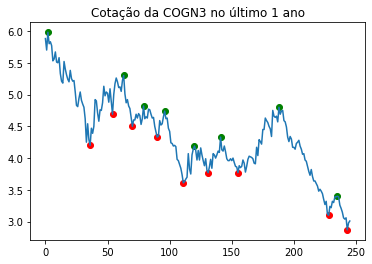

In [560]:
plt.title("Cotação da COGN3 no último 1 ano")
plt.scatter(df_max.index, df_max['min'], c='r')
plt.scatter(df_max.index, df_max['max'], c='g')
plt.plot(df_max.index, df_max['COGN3.SA'])
plt.show()

In [582]:
df_max = pd.DataFrame(df_close['BRPR3.SA'])
df_max.reset_index(drop=True, inplace=True)
n = 10
df_max['min'] = df_max.iloc[argrelextrema(df_max['BRPR3.SA'].values, np.less_equal,
                    order=n)[0]]['BRPR3.SA']
df_max['max'] = df_max.iloc[argrelextrema(df_max['BRPR3.SA'].values, np.greater_equal,
                    order=n)[0]]['BRPR3.SA']

# a = argrelextrema(df_close['COGN3.SA'].values, np.less_equal, order=n)[0]
# a

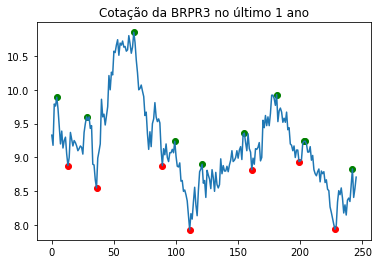

In [565]:
plt.title("Cotação da BRPR3 no último 1 ano")
plt.scatter(df_max.index, df_max['min'], c='r')
plt.scatter(df_max.index, df_max['max'], c='g')
plt.plot(df_max.index, df_max['BRPR3.SA'])
plt.show()

In [566]:
df_max['max'].dropna()

4       9.89
28      9.60
66     10.85
99      9.24
121     8.90
155     9.36
181     9.93
203     9.24
204     9.24
242     8.83
Name: max, dtype: float64

In [583]:
picos = {}
mins = {}
maxs = {}

for column in list(df_close.columns):
    mins[column] = (len(argrelextrema(df_close[column].values, np.less_equal, order=n)[0]))
    maxs[column] = (len(argrelextrema(df_close[column].values, np.greater_equal, order=n)[0]))

In [584]:
df_list = [(selic, 'Selic'), (prefixado, 'Prefixado'), (ipca, 'IPCA'), (hash11, 'HASH11.SA'), (tgar11, 'TGAR11.SA'),
           (biau39, 'BIAU39.SA'), (gold11, 'GOLD11.SA'), (xina11, 'XINA11.SA')]

for df in df_list:
    mins[df[1]] = (len(argrelextrema(df[0]['Último'].values, np.less_equal, order=n)[0]))
    maxs[df[1]] = (len(argrelextrema(df[0]['Último'].values, np.greater_equal, order=n)[0]))

In [598]:
keys = mins
# alpha = np.nextafter(np.float32(0), np.float32(1))
model = Model()
x = model.continuous_var_dict(keys, name='invs')
model.maximize(model.sum(x[i] * maxs[i] for i in keys))

In [599]:
model.add_constraints(x[i] >= 0.01 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)

docplex.mp.LinearConstraint[](invs_ALSO3.SA+invs_ALUP11.SA+invs_AURA33.SA+invs_BABA34.SA+invs_BOVA11.SA+invs_BRML3.SA+invs_BRPR3.SA+invs_COGN3.SA+invs_CSAN3.SA+invs_CYRE3.SA+invs_DIRR3.SA+invs_EGIE3.SA+invs_FESA4.SA+invs_GGBR4.SA+invs_GOAU4.SA+invs_IVVB11.SA+invs_JHSF3.SA+invs_KNRI11.SA+invs_MXRF11.SA+invs_OIBR3.SA+invs_RAIZ4.SA+invs_SULA11.SA+invs_TAEE11.SA+invs_TEND3.SA+invs_TRIS3.SA+invs_TRPL4.SA+invs_VIVT3.SA+invs_XPCI11.SA+invs_Selic+invs_Prefixado+invs_IPCA+invs_HASH11.SA+invs_TGAR11.SA+invs_BIAU39.SA+invs_GOLD11.SA+invs_XINA11.SA,EQ,1)

In [600]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 33 columns.
Reduced LP has 1 rows, 3 columns, and 3 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            10.290000


In [601]:
model.print_solution()

objective: 10.290
  invs_ALSO3.SA=0.010
  invs_ALUP11.SA=0.010
  invs_AURA33.SA=0.010
  invs_BABA34.SA=0.010
  invs_BOVA11.SA=0.010
  invs_BRML3.SA=0.010
  invs_BRPR3.SA=0.010
  invs_COGN3.SA=0.010
  invs_CSAN3.SA=0.010
  invs_CYRE3.SA=0.150
  invs_DIRR3.SA=0.150
  invs_EGIE3.SA=0.010
  invs_FESA4.SA=0.010
  invs_GGBR4.SA=0.010
  invs_GOAU4.SA=0.010
  invs_IVVB11.SA=0.010
  invs_JHSF3.SA=0.090
  invs_KNRI11.SA=0.010
  invs_MXRF11.SA=0.150
  invs_OIBR3.SA=0.010
  invs_RAIZ4.SA=0.010
  invs_SULA11.SA=0.010
  invs_TAEE11.SA=0.010
  invs_TEND3.SA=0.150
  invs_TRIS3.SA=0.010
  invs_TRPL4.SA=0.010
  invs_VIVT3.SA=0.010
  invs_XPCI11.SA=0.010
  invs_Selic=0.010
  invs_Prefixado=0.010
  invs_IPCA=0.010
  invs_HASH11.SA=0.010
  invs_TGAR11.SA=0.010
  invs_BIAU39.SA=0.010
  invs_GOLD11.SA=0.010
  invs_XINA11.SA=0.010


In [602]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [603]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [604]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [605]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [607]:
print('Valor encontrado pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Valor encontrado pela função objetivo:  10.29
Retorno total:  -6.7716
Variância total:  91.4183213342942
Total alocado em renda fixa:  0.03
Total alocado em renda variável:  0.97


## Conclusão

#### 2.2.1 Modelo mantendo todas as restrições solicitadas pelo investidor
Neste modelo nós mantivemos as retrições solicitadas pelo investidor, acrescentando nas restrições o investimento em certas ações que são do seu interesse.

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  55.0869632573187
* Retorno total:  7.999999999999997
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.8500000000000001

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  8.25320014528391
* Variância total:  59.99999999999999
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.85

##### Análise de Resultados - Utilizando de restrições pedidas pelo investidor:
Variância entre 55% - 60%<br>
Retorno entre 8% - 8.25%

#### 2.2.2 Modelo removendo algumas restrições entre ativos de renda variável
Neste modelo foram removidas algumas restrições impostas pelo investidor como o investimento em ativos específicos da carteira de acordo com o seu interesse.

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  49.26582378922695
* Retorno total:  7.999999999999998
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.85

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  8.25320014528391
* Variância total:  59.99999999999999
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.85

##### Análise de Resultados - Ao retirar o investimento de ativos específicos:
Variância entre 49% - 60%<br>
Retorno entre 8% - 8.25%

Percebemos uma diminuição da variância final encontrada pelo modelo. Isso pode ocorrer pois, ao restringir ativos específicos ao modelo, o investidor pode estar sujeito a erros e escolher ativos que no final possuem, nesse caso, alta variância e possivelmente menores retornos. 

#### 2.2.3 Modelo removendo algumas restrições e utilizando faixas de restrições

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  60.44593636350359
* Retorno total:  7.999999999999998
* Total alocado em renda fixa:  0.19999999999999987
* Total alocado em renda variável:  0.7999999999999999

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  7.781820424042756
* Variância total:  60.00000000000001
* Total alocado em renda fixa:  0.1999999999999999
* Total alocado em renda variável:  0.8

##### Análise de Resultados - Ao retirar o investimento de ativos específicos e ao utilizarmos faixas de restrições:
Variância entre 60% - 60.45%<br>
Retorno entre 7.8% - 8%

Podemos ver uma leve queda no retorno total e o estreitamento dos valores da variância. Isso aconteceu devido à possibilidade que a faixa de restrições deu ao modelo de alocar até 80% do investimento em rendas variáveis e maior alocamento em rendas fixas que podem não ser a melhor opção para investimento seguindo esses objetivos.

#### 2.2.4 Modelo mais livre

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  47.78417842637107
* Retorno total:  7.999999999999998
* Total alocado em renda fixa:  0.015
* Total alocado em renda variável:  0.985

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  11.600042885457142
* Variância total:  59.99999999999999
* Total alocado em renda fixa:  0.015
* Total alocado em renda variável:  0.9849999999999999

##### Análise de Resultados - Modelo mais livre:
Variância entre 47% - 60%<br>
Retorno entre 8% - 11.6%

Ao retirarmos as retrições para investimento o modelo conseguiu encontrar os melhores resultados dentre todos os já apresentados. Pois, ao eliminar a restrição de ativos específicos e de grupos de ativos na obrigatoriedade da carteira, foi apresentado para nós os melhores investimentos no decorrer de 1 ano.

A variância mínima encontrada para a carteira de 47%
E retorno máximo encontrado de 11.6%

Com isso podemos observar o poder que o modelo tem de escolher os melhores ativos. E, além disso, como os interesses particulares dos investidores podem afetar bastante o resultado final de acordo com certas restrições impostas.

Sendo uma boa opção deixar o modelo mais liberto e alimentá-lo com dados variados para posterior análise!